# 1D convection and diffusion on a fin
Finned surfaces are used in order to achieve higher heat exchange between solid and fluid surfaces. These can be found in many applications: air-cooled internal combustion engines, gas-liquid heat exchangers, cooling systems for electrical components.
The simplest fin - which will be studied in this notebook - has a constant rectangular cross section, as shown in the figure below.

![fin](img/fin.png)

Some hypotesis can be made in order to evaluate the thermal performance of the fin:
1. One-dimensional thermal field.
2. Stationary analysis.
3. Constant thermal conductivity. 
4. Heat exchange due to radiation is neglectable.
5. No heat generation.
6. Convective heat exhange coefficient does not change within the fin length.

## Finite Volumes analysis
By dividing the fin in a certain number of small *control volumes*, it is possible to write the **energy balance equation** on each of them.

![balance](img/fin2.png)

With the notation described in the figure above, the energy balance for a generic control volume is:

$$-q_w+q_e+q_{conv}=0$$

The conductive terms $q_w$ and $q_e$ can be expressed with *Fourier's law*:

$$q_i = -k\cdot A_{c_i} \cdot \left(\frac{dT}{dx}\right)_i\quad i=w,e$$

where $A_{c_i}$ is the cross section of the i-th face of the control volume.

The convective term can be expressed with the *Newton's law*:

$$q_{conv}=\Delta S \cdot h \cdot \left(T_P-T_{\infty}\right)$$

In case of constant rectangular cross section, $\Delta S = P\cdot \Delta x$ where $P$ is the perimeter of the fin (both the upper and lower surface).

The energy balance can therefore be formulated as:

$$k\cdot A_{c_w} \cdot \left(\frac{dT}{dx}\right)_w - k\cdot A_{c_e} \cdot \left(\frac{dT}{dx}\right)_e + \Delta S \cdot h \cdot \left(T_P-T_{\infty}\right) = 0$$

If a *2nd order central difference scheme* (CDS) is used to evaluate the fluxes, these can be written as:

$$\left(\frac{dT}{dx}\right)_w \approx \frac{T_P - T_W}{\Delta x}$$

and

$$\left(\frac{dT}{dx}\right)_e \approx \frac{T_E - T_P}{\Delta x}$$

So, for a generic (inner) CV, the balance is:

$$A_WT_W+A_PT_P+A_ET_E=S_P$$

where:

$S_P = -\Delta S \cdot h \cdot T_{\infty}$

$A_W = \frac{k A_{c_w}}{\Delta x}$

$A_E = \frac{k A_{c_e}}{\Delta x}$

$A_P = - \left(A_W+A_E \right) - \Delta S \cdot h$

### Problem 1
A fin is made of silicon, which has a thermal conductivity of $k=148.7 W/(m K)$ at room temperature $T_{\infty} = 25 ^oC$. The convective coefficient is $h=200W/(m^2 K) $ at $T_{\infty} = 25 ^oC$.

The fin is $t=1 mm$ thick, $L=20 mm$ long, and has a very big depth.
One side of the fin is held at $T_b=200 ^oC$, whereas the other side can be assumed to be perfectly insulated (no heat exchange).

It is required to evaluate the thermal flux (per depth unit) $q^{'}_{num}$ exchanged by a plain fin with the finite volumes method. The numerical results, obtained with $N=10,20,40,80,160$ finite volumes, should then be compared with the analytical solution, given by

$$q'_f=\sqrt{hPkA_c}\cdot\tanh (m L) \cdot \left(T_b - T_{\infty}\right)\quad [W/m]$$

where $m=\sqrt{\frac{hP}{kA_c}}$

### Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

First, let's define some properties.

In [2]:
T_room = 25 + 273.15 # Kelvin
k = 148.7 # W/(mK)
h = 200 # W/(m2K)
t = 1e-3 # m
w = 1 # m
L = 20e-3 # m
A_c = t * w # cross section

Since the thickness is small (with respect to the length), a 1D analysis can be performed.

The domain must be discretized. For the sake of simplicity, let's assume (for the moment) that $n=10$. Later on, we will vary the number of finite volumes.

The idea is to evaluate the temperature at the centroid of each FV, and then estimate the total heat exchanged as the sum of the fluxes exchanged by each FV.

In [3]:
n = 10
dx = L / n # element length
Delta_S = 2 * w * dx

Now we can define the coefficients $A_i$, which are constant for each inner FVs. 

The boundaries FV will be corrected later on.

In [4]:
A_W = k * A_c / dx
A_E = k * A_c / dx
A_P = - (A_W + A_E) - Delta_S * h
S_P = - Delta_S * h * T_room

In order to evaluate the temperatures at each CV centroid, a system of $n$ equations must be solved.
Given the general system

$$Ax-b=0$$

in this case the matrix A will be a $n\times n$ **tri-diagonal** matrix.
Our task in therefore to build the matrices A and b, and then to solve the linear system.

The diagonals of A are made as follows.

In [5]:
D_W = A_W * np.ones((n, ))
D_E = A_E* np.ones((n, ))
D_P = A_P * np.ones((n, ))
S = S_P * np.ones((n, ))

#### Boundary conditions
Now, let's modify those diagonals in order to impose the boundary conditions.
In detail, on the left end we will apply a *Dirichlet BC*, because the value of T on the surface is given. Therefore

$ A_P = A_P - A_W$

$ S_P = S_P - 2A_WT_{BC}$

where $T_{BC}$ is known (right-hand side) and $A_P$ is unknown.

In [6]:
T_BC = 200 + 273.15 # K
D_P[0] = D_P[0] - D_W[0]
S[0] = S[0] - 2 * D_W[0] * T_BC
D_W[0] = 0

On the right end, a *Neumann BC* will be applied.

$ A_P = A_P + C_{lhs} \cdot A_E $

$ S_P = S_P - C_{rhs} \cdot A_E $

where $C_{lhs} = \frac{2k}{2k+\alpha\Delta x}$ and $C_{rhs} = \frac{\alpha\Delta x}{2k+\alpha\Delta x}$. Since the right end of the fin can be assumed to be perfectly insulated, $\alpha=0$. 

In [7]:
alpha = 0
C_lhs = 2*k / (2*k + alpha*dx)
C_rhs = alpha*dx / (2*k + alpha*dx)

D_P[-1] = D_P[-1] + D_E[-1]*C_lhs
S[-1] = S[-1] - D_E[-1]*C_rhs
D_E[-1] = 0

#### Sparse matrix

It is possible now to assembly the A matrix, using the *diags* command, and then solve the linear system.

In [8]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

D = [D_W[1:], D_P, D_E[:-1]]
A = diags(D, [-1, 0, 1], (n, n), format='csc')

T = spsolve(A, S)

It is now possible to plot the temperature for each FV.

In [10]:
A.toarray().round()

array([[-224.,   74.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [  74., -150.,   74.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,   74., -150.,   74.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,   74., -150.,   74.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,   74., -150.,   74.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,   74., -150.,   74.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,   74., -150.,   74.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,   74., -150.,   74.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,   74., -150.,
          74.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   74.,
         -75.]])

Text(0.5, 1.0, 'Temperature in the fin with 10 FVs')

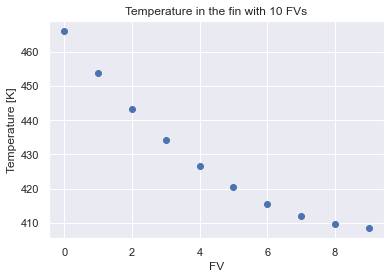

In [9]:
import seaborn as sns
sns.set()
plt.plot(T, 'o')
plt.xlabel('FV')
plt.ylabel('Temperature [K]')
plt.title('Temperature in the fin with {} FVs'.format(n))

The behaviour seems reasonable. Let's now evaluate the total flux, which is the sum of the heat exchanged by each FV.

$$q{'}_{conv} = (T_{FV} - T_{\infty}) \cdot 2\Delta x \cdot h$$

And compare it to the analytical one.

In [11]:
flux_num = np.sum((T - T_room) * h * 2 * dx * w)
P = 2 * w
m = np.sqrt(h * P / k / A_c)
flux_th = np.sqrt(h * P * k * A_c) * np.tanh(m * L) * (T_BC - T_room)
print('The error is: {:.2f}'.format(flux_th - flux_num))

The error is: 1.66


Since the error is low, the implementation seems to be correct.

Now, we should refactor the code into a function, which allows us to compute the error for a range of FVs numbers.

The following code is merely a refactoring of the previously explained code.

In [17]:
def OneDimFin(n, L=20e-3, w=1,
              T_BC=200, T_room=25,
              h=200, k=148.7, alpha=0):
    """
    Evaluate the difference between analitical and numerical solution
    for 1D convection and conduction on a fin.
    """
    
    T_BC = T_BC + 273.15
    T_room = T_room + 273.15
    dx = L / n # element length
    Delta_S = 2 * w * dx
    A_W = k * A_c / dx
    A_E = k * A_c / dx
    A_P = - (A_W + A_E) - Delta_S * h
    S_P = - Delta_S * h * T_room
    D_W = A_W * np.ones((n, ))
    D_E = A_E* np.ones((n, ))
    D_P = A_P * np.ones((n, ))
    S = S_P * np.ones((n, ))

    D_P[0] = D_P[0] - D_W[0]
    S[0] = S[0] - 2 * D_W[0] * T_BC
    D_W[0] = 0

    C_lhs = 2*k / (2*k + alpha*dx)
    C_rhs = alpha*dx / (2*k + alpha*dx)

    D_P[-1] = D_P[-1] + D_E[-1]*C_lhs
    S[-1] = S[-1] - D_E[-1]*C_rhs
    D_E[-1] = 0

    D = [D_W[1:], D_P, D_E[:-1]]
    A = diags(D, [-1, 0, 1], (n, n), format='csc')

    T = spsolve(A, S)

    flux_num = np.sum((T - T_room) * h * 2 * dx * w)
    P = 2 * w
    m = np.sqrt(h * P / k / A_c)
    flux_th = np.sqrt(h * P * k * A_c) * np.tanh(m * L) * (T_BC - T_room)
    error = flux_th - flux_num
    
    return T, flux_num, error

It is possible now to answer the question of the problem with a few lines of code. For reference, $y=x^{-2}$ is also plotted.

Text(0.5, 1.0, 'Numerical error')

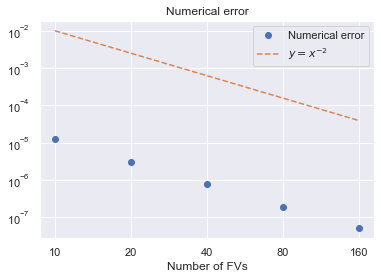

In [18]:
FVs = np.array([10, 20, 40, 80, 160])

errors = []
for i, num in zip(range(5), FVs) :
    _, _, error = OneDimFin(num)
    errors.append(error)

plt.loglog(FVs, errors, 'o', label='Numerical error')
x = np.linspace(10, 160, 100)
plt.loglog(x, x**(-2), '--', label=r'$y=x^{-2}$')
plt.xticks(ticks=FVs, labels=FVs)
plt.xlabel('Number of FVs')
plt.legend()
plt.title('Numerical error')

## Problem 2
Perform the same analysis in the case that the thermal conductivity of silicon is a function of the temperature, as follows

$$k=k_{\infty}\left(1+\beta\left(T-T_{\infty}\right)\right)$$

where 
$$\beta=\frac{k_b/k_{\infty}-1}{T_b-T_{\infty}}$$

with $k_{\infty}=148.7 W/(m K)$ and $k_{b}=85.8 W/(m K)$ thermal conductivities of silicon at $T_{\infty}$ and $T_b$, respectively.
The numerical approximation will be compared to some approximated analytical solutions, which are $q^{'}_f=809.4 W/m$ and $q^{''}_f=940.1 W/m$.

### Solution
Given the non-linearity of the problem, an iterative approach must be used. The temperature at the FVs centroids and the thermal conductivities at their faces will be updated at each iteration, until convergence will be reached. 

The adopted iterative scheme is:
1. Estimation of $k$ at the FVs faces, with a harmonic mean between FVs centroids.
2. Evaluation of the temperature at the FVs centroids.
3. Correction of $k$ in the FVs centroids.

Particular attention should be given to the $k$ values at the FVs faces. If $n$ is the number
of FVs, the number of the faces in which the thermal conductivity should be calculated are
$n+1$. The evaluation of $k$ at FVs faces is based on the harmonic mean between the adjacent FVs.

$$k_{hm,i}=\frac{2\cdot k_i \cdot k_{i+1}}{k_i + k_{i+1}} \quad i=1,...,n-1$$

The values of $k_hm$ at the left and right end of the fin are, respectively, $k_{hm,0}=k_b$ and $k_{hm,n}=k_{hm,n-1}$.

In [192]:
def OneDimFinNonLinear(n, nIter=10, L=20e-3, w=1,
                       T_BC=200, T_room=25,
                       h=200, k_0=148.7, k_b=85.8, alpha=0):
    """
    Evaluate the difference between analitical and numerical solution
    for 1D convection and conduction on a fin.
    The thermal conductivity depends on the temperature.
    """
    # Results
    Ts = []
    errors = []
    flux_nums = []
    
    T_BC = T_BC + 273.15
    T_room = T_room + 273.15
    beta = ((k_b / k_0) - 1) / (T_BC - T_room)
    dx = L / n # element length
    Delta_S = 2 * w * dx
    
    k = k_0 * np.ones((n, ))
    k_hm = k_0 * np.ones((n+1, ))
    
    for i in np.arange(nIter):
        k_hm[0] = k_b
        k_hm[-1] = k[-1]
        k_hm[1:-1] = (2 * k[:-1] * k[1:]) / (k[:-1] + k[1:])
        
        A_W = k_hm[:-1] * A_c / dx
        A_E = k_hm[1:] * A_c / dx
        A_P = - (A_W + A_E) - Delta_S * h
        S_P = - Delta_S * h * T_room
        D_W = A_W
        D_E = A_E
        D_P = A_P * np.ones((n, ))
        S = S_P * np.ones((n, ))

        D_P[0] = D_P[0] - D_W[0]
        S[0] = S[0] - 2 * D_W[0] * T_BC
        D_W[0] = 0

        C_lhs = 2*k_hm[0] / (2*k_hm[0] + alpha*dx)
        C_rhs = alpha*dx / (2*k_hm[-1] + alpha*dx)

        D_P[-1] = D_P[-1] + D_E[-1]*C_lhs
        S[-1] = S[-1] - D_E[-1]*C_rhs
        D_E[-1] = 0

        D = [D_W[1:], D_P, D_E[:-1]]
        A = diags(D, [-1, 0, 1], (n, n), format='csc')
        
        # Direct solution
        T = spsolve(A, S)

        # Update k values
        k = k_0 * (1 + beta * (T - T_room))
        
        flux_num = np.sum((T - T_room) * h * 2 * dx * w)
        flux_th1 = 809.4
        flux_th2 = 940.1
        error = flux_num - np.array([flux_th1, flux_th2])
        Ts.append(T)
        flux_nums.append(flux_num)
        errors.append(np.abs(error))
        
    return Ts, flux_nums, errors

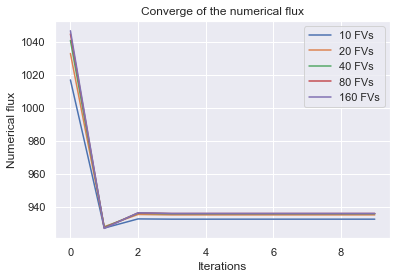

In [193]:
errors = []
for n in FVs:
    T, flux, err = OneDimFinNonLinear(n)
    plt.plot(flux, label='{} FVs'.format(n))
    errors.append(err[-1])
    
plt.xlabel('Iterations')
plt.ylabel('Numerical flux')
plt.title('Converge of the numerical flux')
plt.legend()

## References
[1] E. Nobile, Homework No. 1, April 2018.